# Applications Lecture 2 - Understanding Spectral Peak Shapes with Python and Curve Fitting

#### Credits
Inspiration of the content: Jens Uhlig, from Lund Univeristy; Emily Grace Ripka, from Syracuse University \
Review of the code: Mika Rebensburg, from Lund University \
Exercise 1 Spectrum: Methylene Blue from https://omlc.org/spectra/mb/ \
Exercise 2 Spectrum: https://osdb.stuchalk.domains.unf.edu/

In [1]:
# Autoreload functions to modify our module while working here
%load_ext autoreload
%autoreload 2

#Import the necessary modules
#For data visualization
import matplotlib.pyplot as plt
import matplotlib as mat

#Fot data manipulation
import numpy as np
import pandas as pd
import scipy as scipy
from scipy import optimize

#Python course module
import python_course as pc

### Visualization set-up, the following function and class will be discussed on the lecture!

In [2]:
# Function: pc.plot_curves()
# Class: pc.slice_fun()

# Spectral peaks: where x is wavelength

# Gaussian functions
$$
f(x)= A \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}
$$

Where: \
    $A$ is an amplitude modulator\
    $\mu$ is the mean or expectation of the distribution (and also its median and mode)\
    $\sigma$ is its standard deviation.\
    $\sigma^2$ is the variance of the distribution\
Let's define one single Gaussian function

In [3]:
def gaussian_1(x, a1, s1, u1):
    return a1*(1/(s1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-u1)/s1)**2)))

Where p0 is going to be a numpy array with three entries: amplitude, standard deviation and mean.\
Let's now initialize the parameters, call the function, and plot the curve


In [4]:
p0 = [100, 10, 400] #Example parameters: first is a1, second is s1, third is u1
X = np.linspace(100, 1001, 902) #Example X-Values, can be understood as wavelength values
noise = np.random.rand(902) * 2 - 1

In [5]:
g1 = gaussian_1(X, p0[0], p0[1], p0[2])

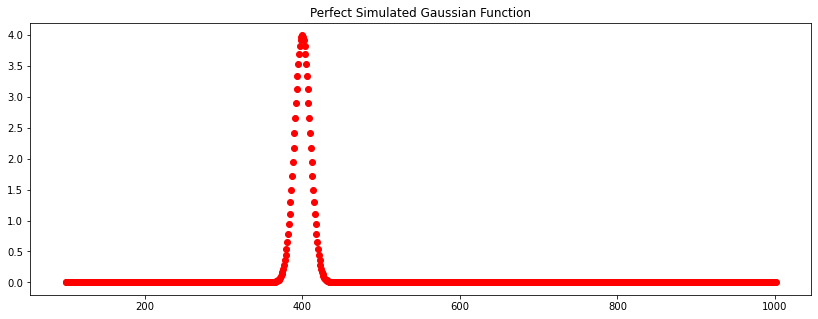

In [6]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(X, g1, c="r")
ax.set_title("Perfect Simulated Gaussian Function")
plt.show()

We can add some noise to the curve to make the simulation more real

In [7]:
g2 = g1 + noise * 0.15

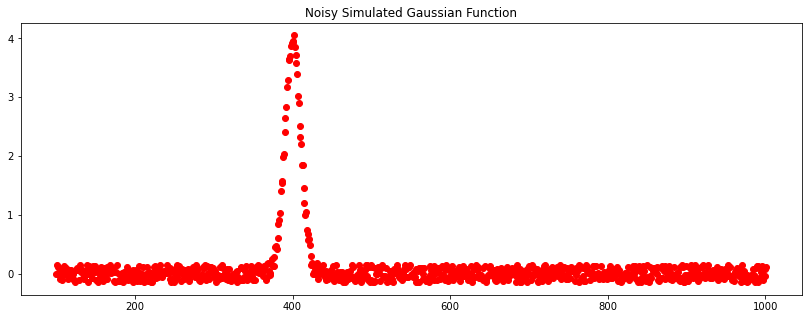

In [8]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(X, g2, c="r")
ax.set_title("Noisy Simulated Gaussian Function")
plt.show()

We can make this picture complex with more Gaussian curves!

In [9]:
def gaussian_2(x, a1, s1, u1, a2, s2, u2):
    return a1*(1/(s1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-u1)/s1)**2))) +\
        a2*(1/(s2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-u2)/s2)**2)))

In [10]:
p0, p1 = [100, 10, 400], [70, 5, 500] #Example parameters for two curves
g3 = gaussian_2(X, p0[0], p0[1], p0[2], p1[0], p1[1], p1[2]) + noise * 0.15

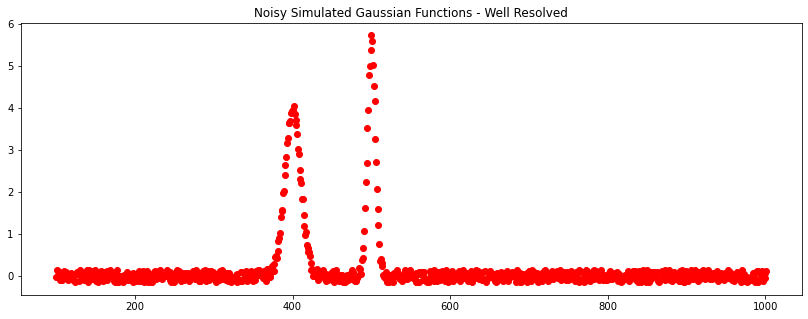

In [11]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(X, g3, c="r")
ax.set_title("Noisy Simulated Gaussian Functions - Well Resolved")
plt.show()

In the previous examples the peaks are well resolved, and their center can be easily identified by eye. However, that is not the situation in the following case:

In [12]:
p0, p1 = [70, 6, 600], [100, 9, 620]
g4 = gaussian_2(X, p0[0], p0[1], p0[2], p1[0], p1[1], p1[2]) + noise * 0.15

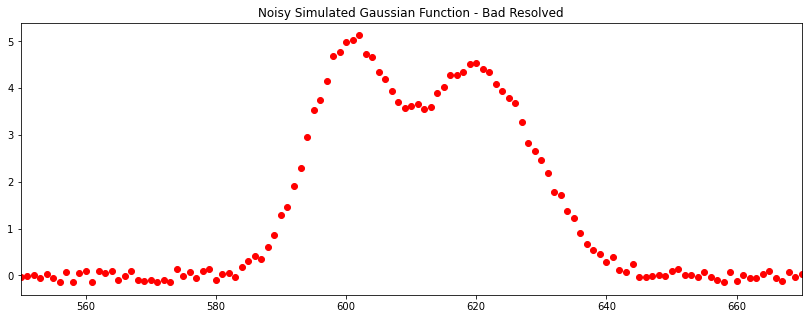

In [13]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(X, g4, c="r")
ax.set_title("Noisy Simulated Gaussian Function - Bad Resolved")
ax.set_xlim(550, 670)
plt.show()

Module scipy.optimize has a function for fitting any curve to any function giving an initial guess of its parameters

In [14]:
popt, pcov = optimize.curve_fit(gaussian_2, X, g4, p0 = [*p0, *p1])

Parameters are stored in the first returned option, while the covarianze in the second one, from whom we can extract the error:
```
perr = np.sqrt(np.diag(pcov))
```


.

In [15]:
perr = np.sqrt(np.diag(pcov))
# Unpack parameters and the standard error of curve 1
popt1 = popt[0:3]
perr1 = perr[0:3]

# Unpack parameters and the standard error of curve 2
popt2 = popt[3:6]
perr2 = perr[3:6]

In [16]:
df=pd.DataFrame({'Real Value':[*p0, *p1], 'Parameter estimation':popt,'Estimation Error':perr},index=['$A_1$','$\sigma_1$','$\mu_1$', '$A_2$','$\sigma_2$','$\mu_2$'])

In [17]:
df

,Real Value,Parameter estimation,Estimation Error
$A_1$,70,69.724274,1.174189
$\sigma_1$,6,6.015959,0.074625
$\mu_1$,600,600.004919,0.089202
$A_2$,100,100.353288,1.263667
$\sigma_2$,9,9.013524,0.118483
$\mu_2$,620,619.993185,0.128003


One important parameters of Gaussian functions is the full width at half maximum, defined as:
$$
FWHM = 2 \sqrt{2\ln 2} \: \sigma \approx 2.355 \sigma
$$
Let's see how much it is

In [18]:
print(df.iloc[1, :] * 2.355)
print(df.iloc[4, :] * 2.355)

Real Value              14.130000
Parameter estimation    14.167584
Estimation Error         0.175741
Name: $\sigma_1$, dtype: float64
Real Value              21.195000
Parameter estimation    21.226850
Estimation Error         0.279027
Name: $\sigma_2$, dtype: float64


We can now simulate every Gaussian alone and the fit curve together

In [19]:
g5 = gaussian_2(X, *popt)
g6 = gaussian_1(X, *popt1)
g7 = gaussian_1(X, *popt2)

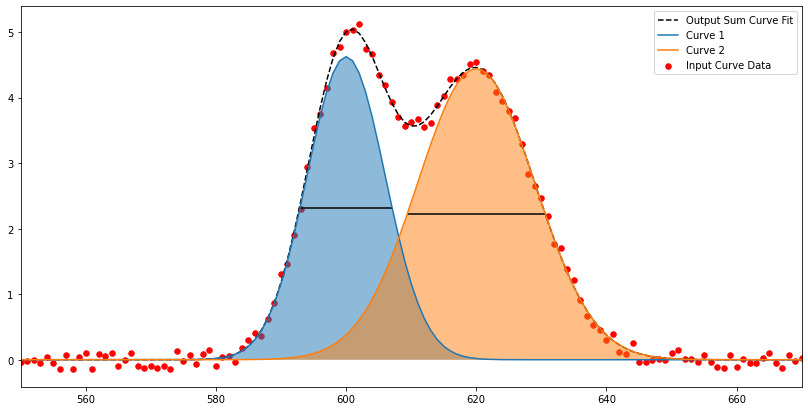

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))
pc.plot_curves(fig, ax, X, g4, g5, g6, g7)
ax.hlines(g6.max()/2, popt1[2]-(df.iloc[1, 1] * 2.355)/2, popt1[2]+ (df.iloc[1, 1] * 2.355)/2, colors="black")
ax.hlines(g7.max()/2, popt2[2]-(df.iloc[4, 1] * 2.355)/2, popt2[2]+(df.iloc[4, 1] * 2.355)/2, colors="black")
ax.set_xlim(550, 670)
plt.show()

When generating multiple gaussian functions, it is possible to define a "gaussian_n" function.\
You can find one preloaded in the python_course module, defined as:
```
pc.gaussian_n(x, *args)
```

In [21]:
p1 = [70, 6, 600]
p2 = [100, 9, 620]
p3 = [80, 5, 440]
p4 = [90, 5, 460]
p5 = [80, 5, 480]

poly_gaussian = pc.gaussian_n(X, p1, p2, p3, p4, p5) + noise * 0.15

Constructed Gaussian as a sum of 5 gaussians


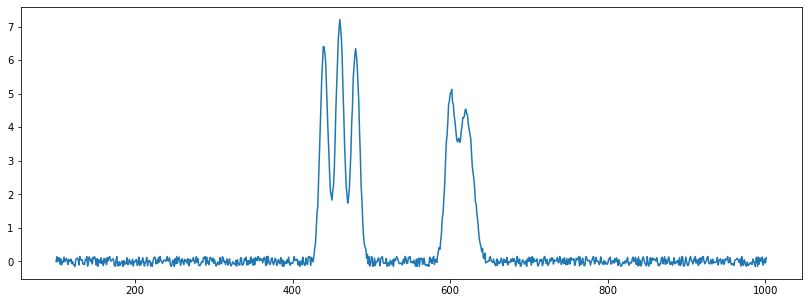

In [22]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(X, poly_gaussian)
plt.show()

However, this Gaussian generator cannot be used for fitting, it does not fullfill scipy.optimize.curve_fit requirements


#### Discussion 1:
How to define a gaussian_n() function that is actually able to fit n gaussians!

.

.

# NMR Lorentzian functions

This is the ideal shape of the real part of the Fourier transformed FID signal in NMR

$$
A(f)=\left[\frac{R}{R^{2}+4\pi^2\left(f-F_{0}\right)^{2}}\right]
$$

Where $F_0$ is the center of the peak and $\frac{R}{\pi}$ is the full width half maximum. Both parameters are given in $Hz$ ($s^{-1}$)

Let's define some Lorentzian functions, although the lor_n is already constructed

In [23]:
def lor_1(x, R, F):
    return (R) / (R**2 + 4 * np.pi**2 * (x-F)**2)

def lor_2(x, R1, F1, R2, F2):
    return (R1) / (R1**2 + 4 * np.pi**2 * (x-F1)**2) +\
        (R2) / (R2**2 + 4 * np.pi**2 * (x-F2)**2)

def lor_3(x, R1, F1, R2, F2, R3, F3):
    return (R1) / (R1**2 + 4 * np.pi**2 * (x-F1)**2) +\
        (R2) / (R2**2 + 4 * np.pi**2 * (x-F2)**2) +\
        (R3) / (R3**2 + 4 * np.pi**2 * (x-F3)**2)

### Let's simulate some NMR data!
Here, function 
```
pc.lor_n(x, *args)
```
can be used as well

In [24]:
#Let's add some peaks at 200, 250, 400, 450, 750, 800, 850 Hz with some noise!
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10 = [20, 200], [20, 250], [10, 400], [10, 450], [11, 785], [5.5, 800], [11, 815], [5, 600], [5, 615], [30, 700]
Y = pc.lor_n(X, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10) + noise * 0.003

Constructed Lorentzian as a sum of 10 lorentzians


In order to add some good interactive visualization, let's employ some parameters!

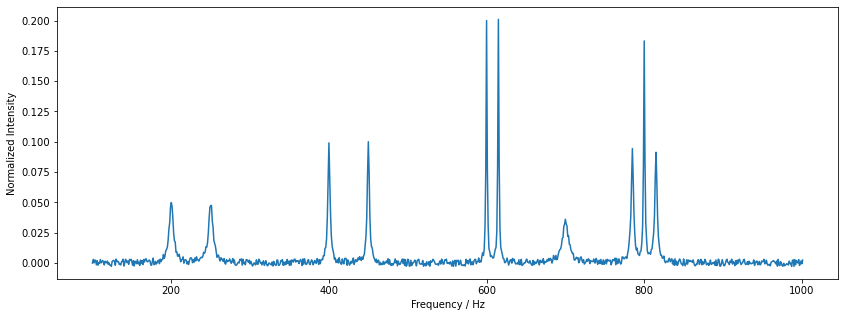

In [25]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(X, Y)
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
plt.show()

#### Discussion 2:
We have simulated an NMR spectrum with 9 peaks, what is the best way to fit it's peaks?

#### Possible method: Slicing sections of the graph
It is based in the interactive widgets provided by matplotlib, and discussed previosly in the visualization lectures.\
We will generate 5 slices of the previous data set in a GRAPHICAL way.\
Of course, non-graphical methods might be used as well, but they might be more time-consuming.

Check out how this works fitting one of the peaks!

In [26]:
# Let's select the triplet area
%matplotlib qt
sec1 = pc.slice_fun(X, Y)

You have the following X limits:
X min: 769.0
X max: 837.0
You have the following X limits:
X min: 776.0
X max: 828.0
You have the following X limits:
X min: 774.0
X max: 826.0


In [27]:
%matplotlib inline

In [28]:
popt, pcov = optimize.curve_fit(lor_3, sec1.newx, sec1.newy, p0=[11, 750, 5.5, 800, 11, 850])
perr = np.sqrt(np.diag(pcov))

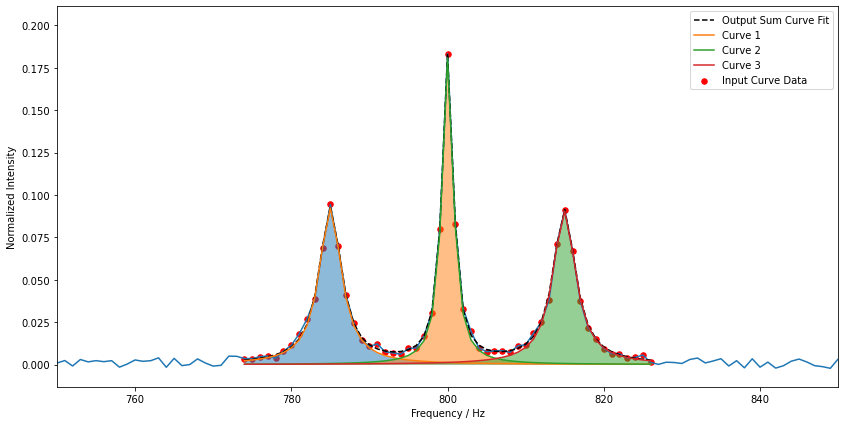

In [29]:
fig, ax = plt.subplots()
ax.plot(X, Y)
pc.plot_curves(fig, ax, sec1.newx, sec1.newy, lor_3(sec1.newx, *popt),
               lor_1(sec1.newx, *popt[0:2]),
               lor_1(sec1.newx, *popt[2:4]),
               lor_1(sec1.newx, *popt[4:6]))
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
ax.set_xlim(750, 850)
plt.show()

.

.

# Exercise 1 in Lecture - UV-VIS spectrum of Methylene Blue
### Try to fit it to Gaussian functions!

In [30]:
path = "data/methylene_blue.txt"

Hints:
- Explore the ".txt" file first. Does it have a header? What is the delimiter of columns? Do you understand the column names and the meaning?
- Visualize your spectrum: understand how many peaks conform every area, think what defined function do you need for the fitting.
- Is it possible to fit all the spectra at once?

In [31]:
# First, read the data. As it has a header, it is necessary to skip it. The delimiter is not a coma, it is a "\t"
data = pd.read_csv(path, sep="\t", index_col=None, skiprows=1, header=0, names = ["nm", "E"])

# Explore the data
data.head()

,nm,E
0,200,12177
1,202,11446
2,204,10687
3,206,9865
4,208,9288


In [32]:
# Normalize to make easier data handling
data["nor"] = data["E"] / data["E"].max()
data.head()

,nm,E,nor
0,200,12177,0.164492
1,202,11446,0.154617
2,204,10687,0.144364
3,206,9865,0.133260
4,208,9288,0.125466


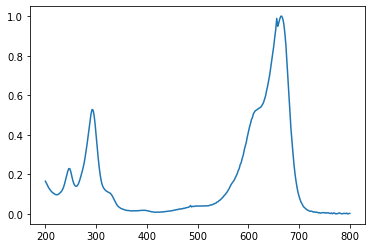

In [33]:
# Perform a quick visualization of your data
plt.plot(data["nm"], data["nor"])

In [34]:
# Slice your function. It is not practical to fit 7 gaussian peaks with our tools!
data_1 = data[(data["nm"] > 222) & (data["nm"] <= 350)]
data_2 = data[data["nm"] > 450]

First Slice

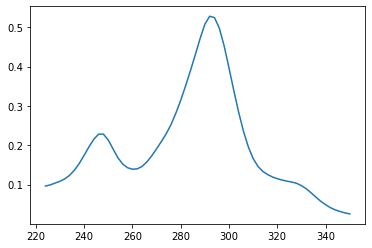

In [35]:
plt.plot(data_1["nm"], data_1["nor"])

In [36]:
# First section seems to have three peaks. Let's define a new Gaussian function
def gaussian_3(x, a1, s1, u1, a2, s2, u2, a3, s3, u3):
    return a1*(1/(s1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-u1)/s1)**2))) + \
        a2*(1/(s2*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-u2)/s2)**2))) + \
        a3*(1/(s3*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-u3)/s3)**2)))

Gaussian FIT

In [37]:
# Let's make the initial guess of the parameters
p0 = [10, 7, 245]
p1 = [14, 11, 292]
p2 = [3, 11, 330]

In [38]:
popt, pcov = optimize.curve_fit(gaussian_3, data_1["nm"], data_1["nor"], p0 = [*p0, *p1, *p2])

In [39]:
fit_curvel = gaussian_3(data_1["nm"], *popt)
curve_1l = gaussian_1(data_1["nm"], *popt[0:3])
curve_2l = gaussian_1(data_1["nm"], *popt[3:6])
curve_3l = gaussian_1(data_1["nm"], *popt[6:9])

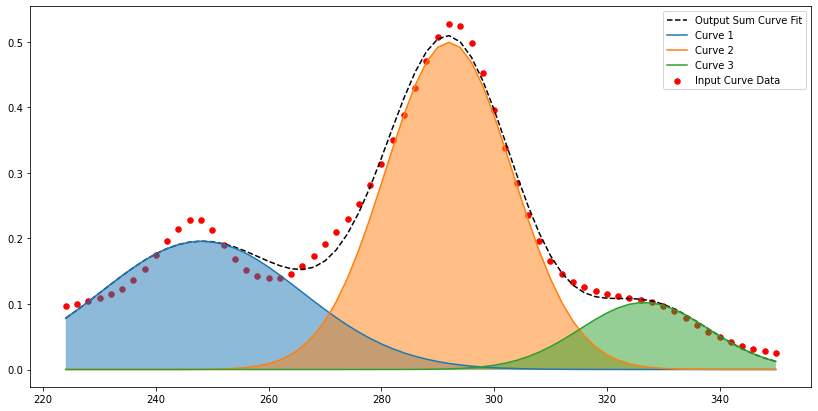

In [40]:
fig, ax = plt.subplots()
pc.plot_curves(fig, ax, data_1["nm"], data_1["nor"], fit_curvel, curve_1l, curve_2l, curve_3l)
plt.show()

Looks that we did not manage to fit super well the left curve. Is it a way to optimize, even more, the parameters? Yes!

In [41]:
# Minimizing the function obtained!!!
# Nelder-Mead is a standard multi-parameter optimiser. Check out other choices.

# This would be the root mean square (we skip the root as the minimum is the minimum)
def min_gauss_3(p):
    return ((data_1["nor"]-gaussian_3(data_1["nm"],*p))**2).sum()

# This is a different cost function that uses a more linear approach. It does not "punish" strong deviations as much. As such it has the tendency to be more outlier stable but preforms bad for peaks.
def min_gauss_lin_3(p): 
    return np.abs(data_1["nor"]-gaussian_3(data_1["nm"], *p)).sum()

In [42]:
out1 = optimize.minimize(min_gauss_3,x0=[*popt],method='Nelder-Mead') 

In [43]:
out2 = optimize.minimize(min_gauss_lin_3,x0=[*popt],method='Nelder-Mead')

In [44]:
out3 = optimize.minimize(min_gauss_3,x0=[*popt],method='Powell')

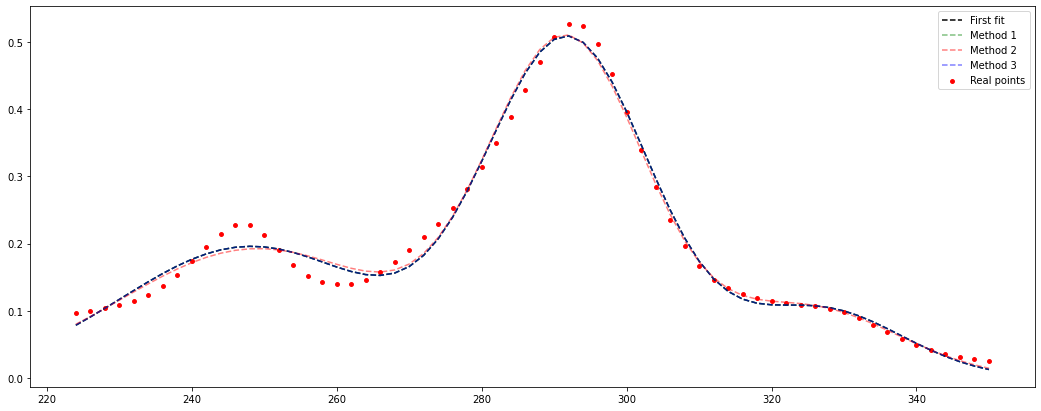

In [45]:
fig, ax = plt.subplots(figsize=(18, 7))
ax.scatter(data_1["nm"], data_1["nor"], s=15, c="r", label="Real points")
ax.plot(data_1["nm"], fit_curvel, ls="--", c="k", label="First fit")
ax.plot(data_1["nm"], gaussian_3(data_1["nm"], *out1['x']), c="green", ls="--", alpha=0.5, label="Method 1")
ax.plot(data_1["nm"], gaussian_3(data_1["nm"], *out2['x']), c="red", ls="--", alpha=0.5, label="Method 2")
ax.plot(data_1["nm"], gaussian_3(data_1["nm"], *out3['x']), c="blue", ls="--", alpha=0.5, label="Method 3")
ax.legend()
plt.show()

We do not manage to improve a lot the parameters, but they are more optimal than before. Why?

Second Slice

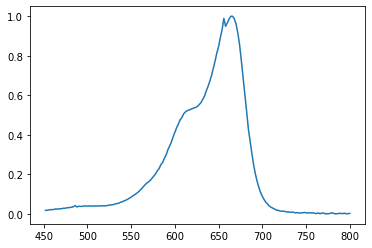

In [46]:
plt.plot(data_2["nm"], data_2["nor"])

In [47]:
p0 = 15, 11, 600
p1 = 30, 11, 660

In [48]:
popt, pcov = optimize.curve_fit(gaussian_2, data_2["nm"], data_2["nor"], p0 = [*p0, *p1])

In [49]:
fit_curveh = gaussian_2(data_2["nm"], *popt)
curve_1h = gaussian_1(data_2["nm"], *popt[0:3])
curve_2h = gaussian_1(data_2["nm"], *popt[3:6])

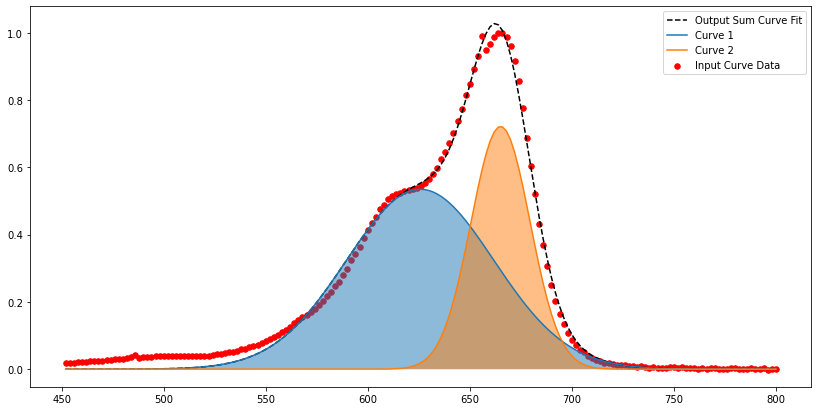

In [50]:
fig, ax = plt.subplots()
pc.plot_curves(fig, ax, data_2["nm"], data_2["nor"], fit_curveh, curve_1h, curve_2h)
plt.show()

Plot everything together!

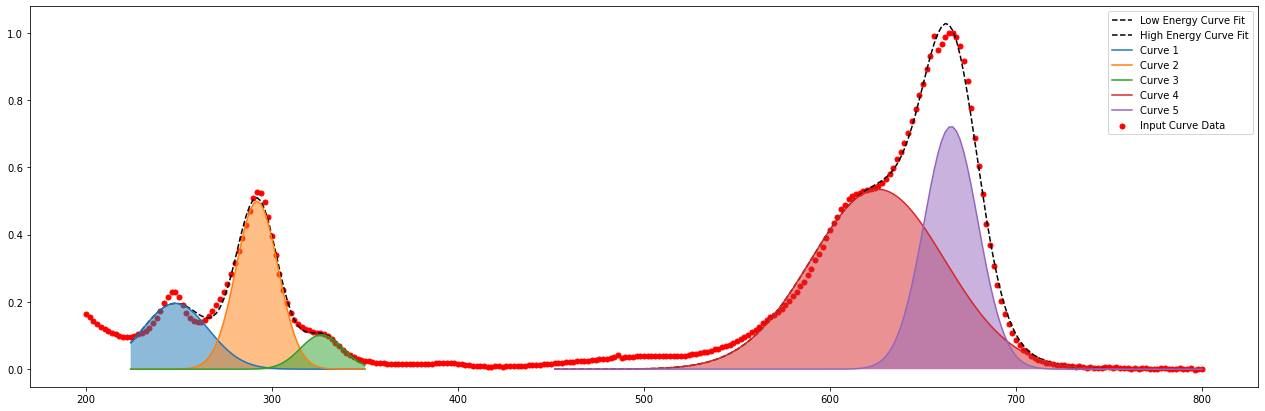

In [51]:
fig, ax = plt.subplots()
ax.scatter(data["nm"], data["nor"], s=25, label="Input Curve Data", c="r")
ax.plot(data_1["nm"], fit_curvel, label="Low Energy Curve Fit", c="k", ls="--")
ax.plot(data_2["nm"], fit_curveh, label="High Energy Curve Fit", c="k", ls="--")
count = 1
for curve in [curve_1l, curve_2l, curve_3l]:
    ax.plot(data_1["nm"], curve, label="Curve {}".format(count))
    ax.fill_between(data_1["nm"], curve.min(), curve, alpha=0.5)
    count = count + 1
for curve in [curve_1h, curve_2h]:
    ax.plot(data_2["nm"], curve, label="Curve {}".format(count))
    ax.fill_between(data_2["nm"], curve.min(), curve, alpha=0.5)
    count = count + 1
ax.legend()
fig.set_size_inches(22, 7)
plt.show()

.

.

# Exercise 2 - NMR of 2-Aminopropane

#### Try to fit the higher frequency peaks to Lorentzian functions!

In [52]:
path2 = "data/amino_propano.csv"

In [53]:
nmr = pd.read_csv(path2, skiprows=1)
nmr.head()

,Frequency (Hz),Intensity
0,4266.600000,-456.6
1,4266.307681,-481.4
2,4266.015362,-566.4
3,4265.723043,-685.0
4,4265.430725,-655.6


In [54]:
#Normalize Intensity
nmr["nor"] = nmr["Intensity"] / nmr["Intensity"].max()
nmr.head()

,Frequency (Hz),Intensity,nor
0,4266.600000,-456.6,-0.000011
1,4266.307681,-481.4,-0.000011
2,4266.015362,-566.4,-0.000013
3,4265.723043,-685.0,-0.000016
4,4265.430725,-655.6,-0.000016


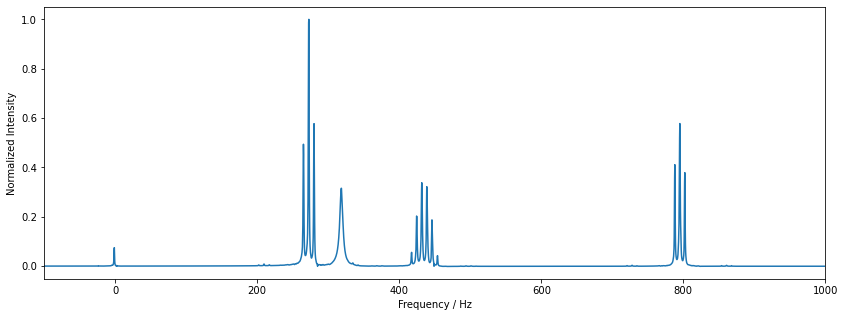

In [55]:
#Explote a bit the data
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(nmr["Frequency (Hz)"], nmr["nor"])
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
ax.set_xlim(-100, 1000)
plt.show()

In [56]:
#Let's study only the right peak!
nmr_high_peak = nmr[(nmr["Frequency (Hz)"] > 780) & (nmr["Frequency (Hz)"] < 815)]
X = nmr_high_peak["Frequency (Hz)"]
y = nmr_high_peak["nor"]

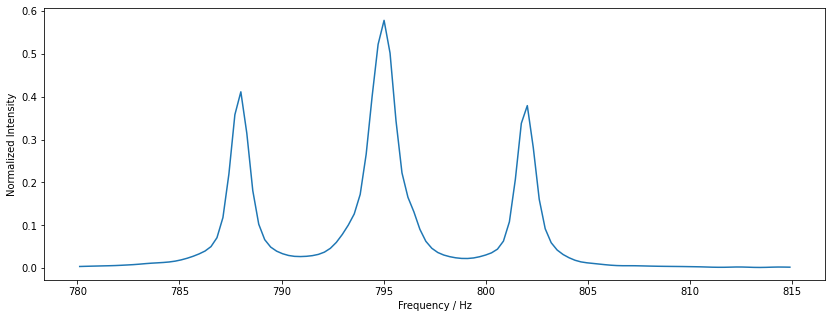

In [57]:
#Plot it
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(X, y)
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
plt.show()

In [58]:
popt, pcov = optimize.curve_fit(lor_3, X, y, p0=[10, 788, 2.5, 795, 10, 802])

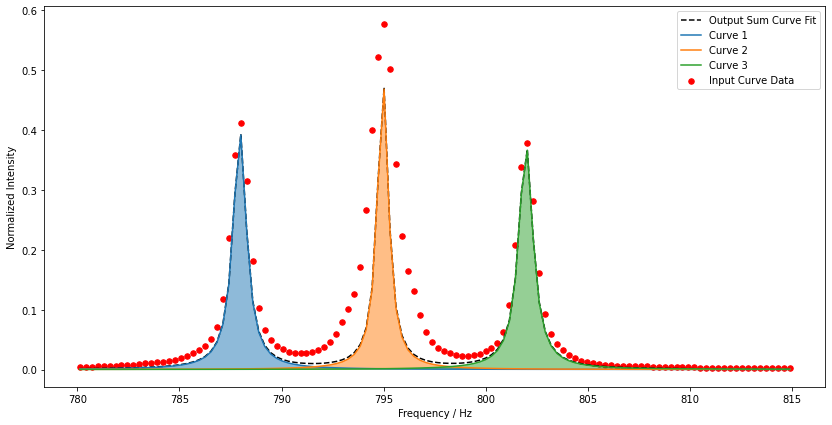

In [59]:
fig, ax = plt.subplots()
pc.plot_curves(fig, ax, X, y, lor_3(X, *popt), lor_1(X, *popt[0:2]), lor_1(X, *popt[2:4]), lor_1(X, *popt[4:6]))
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
plt.show()

#### Why peaks are not that well fit?
Other processes that happen to NMR peaks that affect the line-shape: line broadening by other mechanisms!\
They are not taken into account in our ideal Lorentzian function!
Let's see what happens when fitting with a Gaussian function!

In [60]:
nmr_central_peak = nmr[(nmr["Frequency (Hz)"] > 791) & (nmr["Frequency (Hz)"] < 799)]
X = nmr_central_peak["Frequency (Hz)"]
y = nmr_central_peak["nor"]

In [61]:
popt, pcov = optimize.curve_fit(lor_1, X, y, p0=[*popt[2:4]])
popt2, pcov2 = optimize.curve_fit(gaussian_1, X, y, p0=[1, 1, 795])

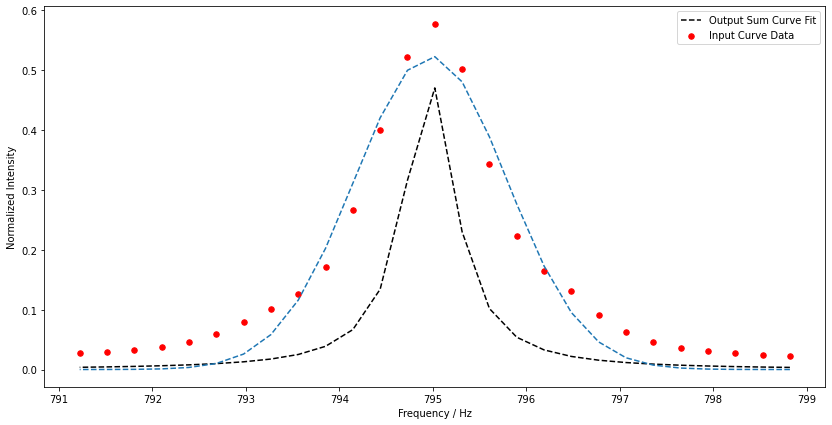

In [62]:
fig, ax = plt.subplots()
pc.plot_curves(fig, ax, X, y, lor_1(X, *popt))
ax.plot(X, gaussian_1(X, *popt2), ls="--")
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
plt.show()

It seems that Gaussian fit captures other features of the curve, but it still not optimal for the fit. Then, what is the solution?

.

.

## Voigt Lineshapes
#### Solution to the problem: new tipe of curve functions!
They are constructed as a sum of both functions with different weight!

In [63]:
def lor_gauss(X, a1, s1, u1, R, F):
    return a1*(1/(s1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((X-u1)/s1)**2))) + \
    (R) / (R**2 + 4 * np.pi**2 * (X-F)**2)

In [64]:
popt, pcov = optimize.curve_fit(lor_gauss, X, y, p0=[1, 1, 795, 1, 795])

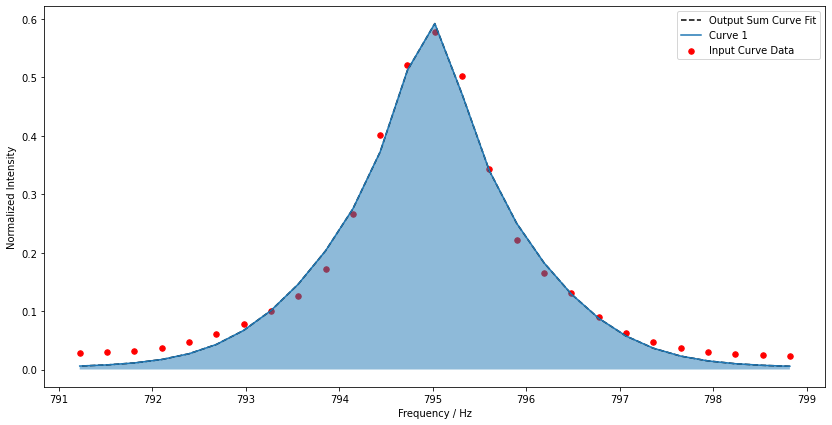

In [65]:
fig, ax = plt.subplots()
pc.plot_curves(fig, ax, X, y, lor_gauss(X, *popt), lor_gauss(X, *popt))
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
plt.show()

How important is every function? That is possible to understand unpacking the curves

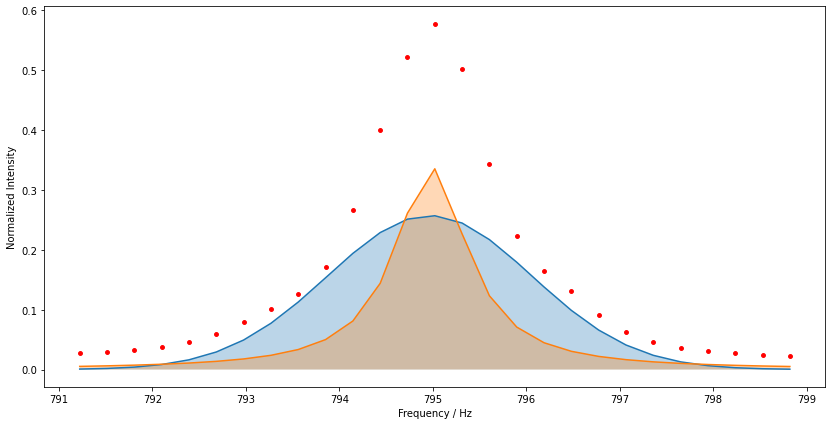

In [69]:
gau_nmr = gaussian_1(X, *popt[0:3])
lor_nmr = lor_1(X, *popt[3:5])

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X, y, c="r", s=15)
ax.plot(X, gau_nmr)
ax.fill_between(X, 0, gau_nmr, alpha=0.3)
ax.plot(X, lor_nmr)
ax.fill_between(X, 0, lor_nmr, alpha=0.3)
ax.set_xlabel("Frequency / Hz")
ax.set_ylabel("Normalized Intensity")
plt.show()

In [67]:
print("Gaussian Parameters: Maximum amplitude = {}, FWHM = {} Hz".format(gau_nmr.max(), popt[1] * 2.355))
print("Lorentzian Parameters: Maximum amplitude = {}, FWHM = {} Hz".format(lor_nmr.max(), popt[3]/np.pi))

Gaussian Parameters: Maximum amplitude = 0.25692211053891917, FWHM = 2.5798414049830494 Hz
Lorentzian Parameters: Maximum amplitude = 0.3353194546016292, FWHM = 0.9432388344085776 Hz


While Gaussian is broader and less intense, Lorentzian is more intense and narrower.